✓ Data berhasil dimuat.
✓ Jumlah baris asli (raw): 1043

MULAI SKENARIO A (WINDOW BESAR)

[Proses] Training Window Size: 30 ...
   -> Window samples: 1013 (window=30)
   -> Selesai epoch : 311
   -> Best epoch    : 211 (val_loss=0.000262)
   -> Last loss     : 0.000794 | Last val_loss : 0.000618
7/7 [==============================] - 4s 32ms/step
   -> MAPE Window 30: 2.5746%


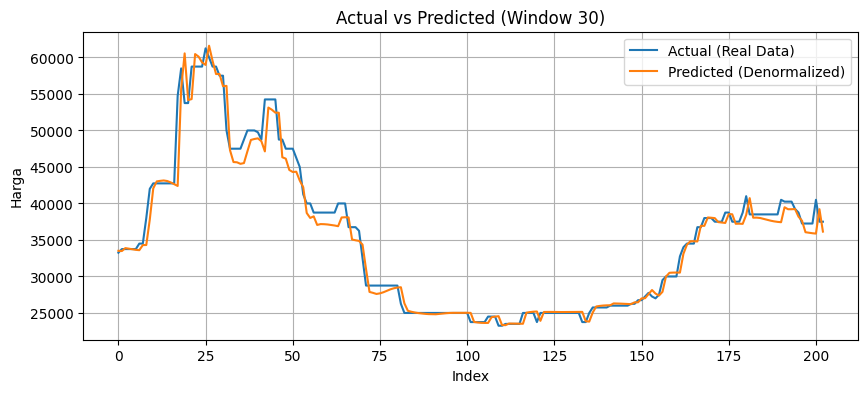

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_30.xlsx

[Proses] Training Window Size: 60 ...
   -> Window samples: 983 (window=60)
   -> Selesai epoch : 324
   -> Best epoch    : 224 (val_loss=0.000248)
   -> Last loss     : 0.000425 | Last val_loss : 0.000257
7/7 [==============================] - 4s 74ms/step
   -> MAPE Window 60: 2.4997%


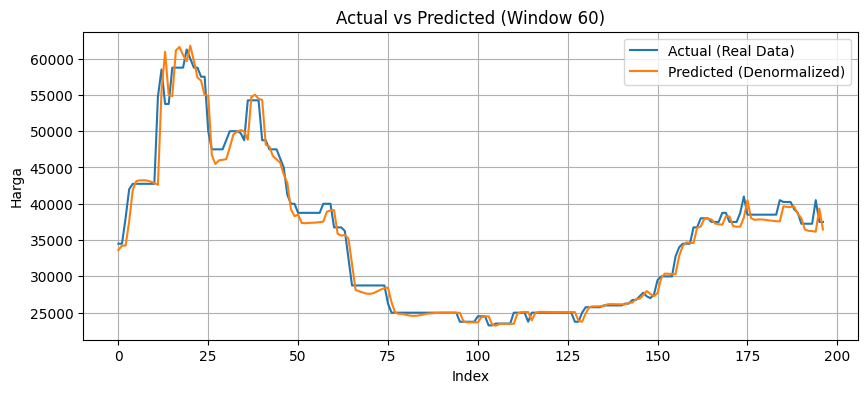

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_60.xlsx

[Proses] Training Window Size: 90 ...
   -> Window samples: 953 (window=90)
   -> Selesai epoch : 366
   -> Best epoch    : 266 (val_loss=0.000385)
   -> Last loss     : 0.000425 | Last val_loss : 0.000419
6/6 [==============================] - 9s 120ms/step
   -> MAPE Window 90: 2.3191%


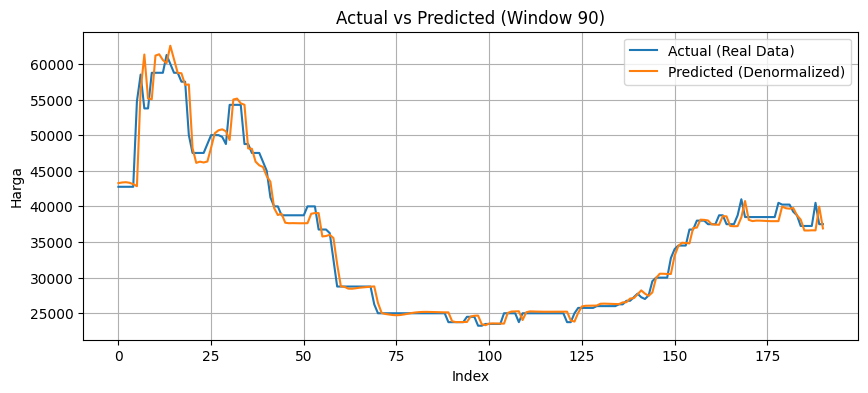

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Window_90.xlsx

   Window Size  MAPE (%)  Best Epoch  Best Loss  Last Loss  Last Val Loss
0           30  2.574564         211   0.000262   0.000794       0.000618
1           60  2.499682         224   0.000248   0.000425       0.000257
2           90  2.319136         266   0.000385   0.000425       0.000419


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==============================
# FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# LOAD DATA
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan!")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah baris asli (raw): {len(raw_data)}")

# ==============================
# SLIDING WINDOW
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

# ==============================
# BANGUN MODEL
# ==============================
def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# KONFIGURASI
# ==============================
scenario_windows = [30, 60, 90]   # WINDOW SIZE sesuai Bab 3
FIXED_EPOCH = 500                 # batas atas; ES pilih terbaik
FIXED_BATCH_SIZE = 30
early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

results = []

print("\n" + "="*50)
print("MULAI SKENARIO A (WINDOW BESAR)")
print("="*50)

# ==============================
# LOOP WINDOW SIZE
# ==============================
for win_size in scenario_windows:
    print(f"\n[Proses] Training Window Size: {win_size} ...")
    reset_seeds()

    # 1) Window di skala asli untuk menentukan split dan y_test asli
    X_full_raw, Y_full_raw = create_sliding_window(raw_data, win_size)
    print(f"   -> Window samples: {len(X_full_raw)} (window={win_size})")  # Saran 2: info jelas
    train_size = int(len(X_full_raw) * 0.8)
    y_test_orig = Y_full_raw[train_size:]  # data uji asli dari Excel (belum normalisasi)

    # 2) Fit scaler HANYA pada segmen TRAIN (hindari leakage)
    raw_train_segment = raw_data[:train_size + win_size]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(raw_train_segment)

    # 3) Transform seluruh data dengan scaler yang di-fit dari TRAIN (tanpa re-fit)
    scaled_data = scaler.transform(raw_data)

    # 4) Windowing pada data yang sudah di-scale
    X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, win_size)

    # 5) Bentuk train/test untuk model dari data ter-scale
    X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
    X_train, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
    y_train = Y_full_scaled[:train_size]

    # 6) Bangun model
    model = build_model_lstm((X_train.shape[1], 1))

    # 7) Training dengan validation_split (tail karena shuffle=False)
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=FIXED_BATCH_SIZE,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False,
        validation_split=0.1  # tail of train (time-series friendly)
    )

    finished_epoch = len(history.history['loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1 if 'val_loss' in history.history else np.argmin(history.history['loss']) + 1
    best_loss = np.min(history.history['val_loss']) if 'val_loss' in history.history else np.min(history.history['loss'])
    last_loss = float(history.history['loss'][-1])  # Saran 3: cetak last loss
    last_val_loss = float(history.history['val_loss'][-1]) if 'val_loss' in history.history else None  # Saran 3

    print(f"   -> Selesai epoch : {finished_epoch}")
    print(f"   -> Best epoch    : {best_epoch} (val_loss={best_loss:.6f})")
    if last_val_loss is not None:
        print(f"   -> Last loss     : {last_loss:.6f} | Last val_loss : {last_val_loss:.6f}")
    else:
        print(f"   -> Last loss     : {last_loss:.6f}")

    # 8) Prediksi pada X_test (scale) → inverse ke skala asli
    predictions_scaled = model.predict(X_test, verbose=1)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # 9) Hitung MAPE terhadap data asli 
    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> MAPE Window {win_size}: {mape:.4f}%")

    results.append({
        'Window Size': win_size,
        'MAPE (%)': float(mape),
        'Best Epoch': int(best_epoch),
        'Best Loss': float(best_loss),
        'Last Loss': float(last_loss),
        'Last Val Loss': float(last_val_loss) if last_val_loss is not None else None
    })

    # ==============================
    # VISUALISASI
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Window {win_size})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL
    # ==============================
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })

    out_path = os.path.join(path_output_folder, f"Prediksi_Window_{win_size}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL
# ==============================
print("\n" + "="*50)
results_df = pd.DataFrame(results)
print(results_df)
print("="*50)

✓ Data berhasil dimuat.
✓ Jumlah baris asli (raw): 1043
✓ Jumlah sampel window: 953 (window=90)
✓ Data ternormalisasi (0-1).

MULAI FASE 2: SKENARIO B (Grid Epoch: 16, 30, 50)
Kondisi: Dengan Normalisasi, Tanpa EarlyStopping (epoch tetap), Val=tail train
Train: (685, 90, 1), Val: (77, 90, 1), Test: (191, 90, 1)

[Training] Epoch = 16, Window = 90
   -> Selesai epoch : 16
   -> Best epoch    : 14 (val_loss=0.001218)
   -> Last loss     : 0.001766 | Last val_loss : 0.001372
6/6 [==============================] - 4s 97ms/step
   -> MAPE          : 4.1190%


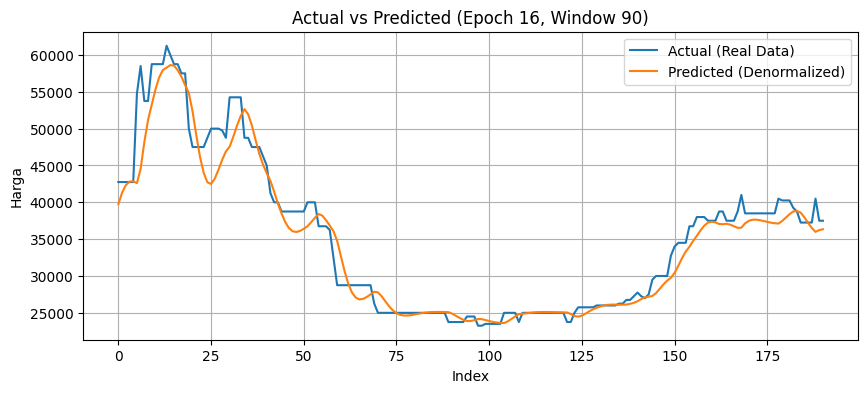

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_16_Window_90.xlsx

[Training] Epoch = 30, Window = 90
   -> Selesai epoch : 30
   -> Best epoch    : 30 (val_loss=0.000986)
   -> Last loss     : 0.001530 | Last val_loss : 0.000986
6/6 [==============================] - 3s 70ms/step
   -> MAPE          : 3.7639%


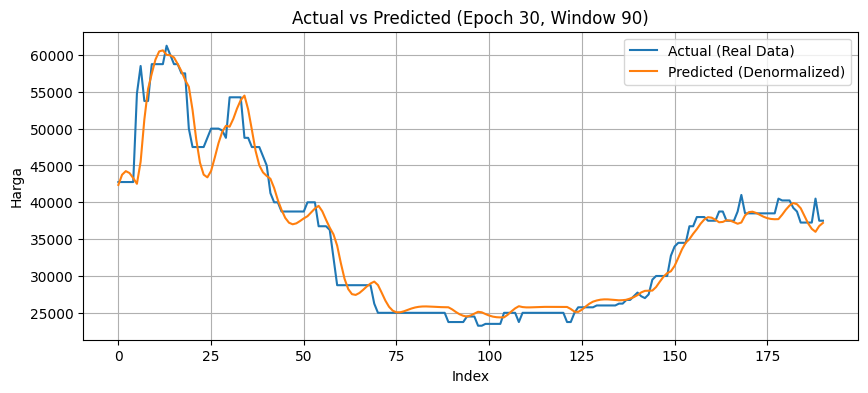

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_30_Window_90.xlsx

[Training] Epoch = 50, Window = 90
   -> Selesai epoch : 50
   -> Best epoch    : 47 (val_loss=0.000808)
   -> Last loss     : 0.001033 | Last val_loss : 0.000959
6/6 [==============================] - 3s 79ms/step
   -> MAPE          : 3.3472%


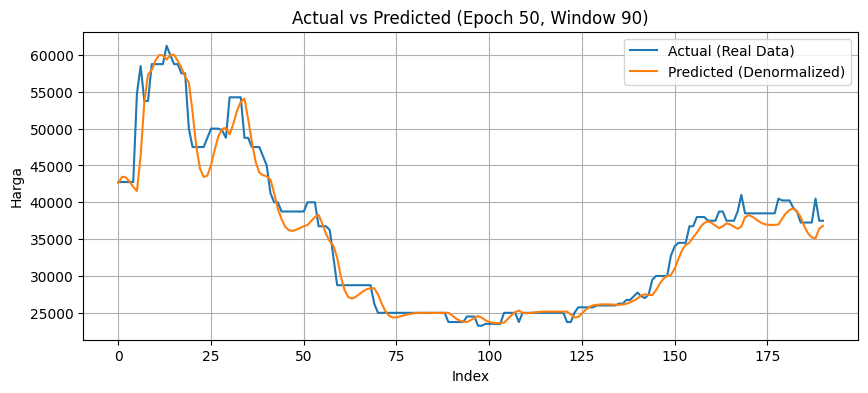

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Epoch_50_Window_90.xlsx

   Jumlah Epoch  Best Epoch (val)  Best Loss (val)  Last Loss  Last Val Loss  \
0            16                14         0.001218   0.001766       0.001372   
1            30                30         0.000986   0.001530       0.000986   
2            50                47         0.000808   0.001033       0.000959   

   MAPE (%)  
0  4.118962  
1  3.763897  
2  3.347179  
Kesimpulan: Epoch terbaik (grid) = 50 dengan MAPE 3.3472%


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==============================
# FIXED SEED
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# PATH
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

# ==============================
# LOAD DATA
# ==============================
if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah baris asli (raw): {len(raw_data)}")

# ==============================
# KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90
FIXED_BATCH_SIZE = 30
scenario_epochs = [16, 30, 50]  # sesuai Bab 3
VAL_RATIO = 0.1                 # validasi dari tail train agar time-series friendly

# ==============================
# FUNGSI
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    # 2 LSTM layer (selaras dengan kode lain)
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# SIAPKAN WINDOW DAN SPLIT DI SKALA ASLI
# ==============================
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
print(f"✓ Jumlah sampel window: {len(X_full_raw)} (window={FIXED_WINDOW_SIZE})")  # Saran no. 1 ditambahkan
train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # data uji asli (sebelum normalisasi)

# Fit scaler HANYA pada segmen TRAIN (hindari leakage)
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data dengan scaler train
scaled_data = scaler.transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# Windowing pada data yang sudah di-scale
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)

# Bentuk train/test untuk model
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

# Split validasi dari tail train (time-series friendly)
val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO B (Grid Epoch: 16, 30, 50)")
print("Kondisi: Dengan Normalisasi, Tanpa EarlyStopping (epoch tetap), Val=tail train")
print("="*60)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

results = []

# ==============================
# LOOP EPOCH TETAP
# ==============================
for epoch_count in scenario_epochs:
    print(f"\n[Training] Epoch = {epoch_count}, Window = {FIXED_WINDOW_SIZE}")
    reset_seeds()

    # Bangun model 2 LSTM layer
    model = build_model_lstm((X_train.shape[1], 1))

    # Training TANPA EarlyStopping (dipaksa selesai), tapi DENGAN validation_data
    history = model.fit(
        X_train, y_train,
        epochs=epoch_count,
        batch_size=FIXED_BATCH_SIZE,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=False
    )

    # Ringkasan training: Best epoch (val_loss), Last loss, Last val_loss
    finished_epoch = epoch_count
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)

    if val_loss is not None:
        best_epoch = int(np.argmin(val_loss) + 1)
        best_loss = float(np.min(val_loss))
        last_loss = float(train_loss[-1])
        last_val_loss = float(val_loss[-1])
        print(f"   -> Selesai epoch : {finished_epoch}")
        print(f"   -> Best epoch    : {best_epoch} (val_loss={best_loss:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f} | Last val_loss : {last_val_loss:.6f}")
    else:
        best_epoch = int(np.argmin(train_loss) + 1)
        best_loss = float(np.min(train_loss))
        last_loss = float(train_loss[-1])
        print(f"   -> Selesai epoch : {finished_epoch}")
        print(f"   -> Best epoch    : {best_epoch} (loss={best_loss:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f}")

    # Evaluasi di TEST (skala asli)
    predictions_scaled = model.predict(X_test, verbose=1)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> MAPE          : {mape:.4f}%")

    # Simpan hasil untuk ringkasan
    results.append({
        'Jumlah Epoch': int(epoch_count),
        'Best Epoch (val)': int(best_epoch),
        'Best Loss (val)': float(best_loss),
        'Last Loss': float(last_loss),
        'Last Val Loss': float(last_val_loss) if val_loss is not None else None,
        'MAPE (%)': float(mape)
    })

    # ==============================
    # VISUALISASI
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Epoch {epoch_count}, Window {FIXED_WINDOW_SIZE})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL (20% test)
    # ==============================
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })
    out_path = os.path.join(path_output_folder, f"Prediksi_Epoch_{epoch_count}_Window_{FIXED_WINDOW_SIZE}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL RINGKASAN
# ==============================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)
print("="*60)

# Tampilkan kesimpulan MAPE terendah
best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_epoch = int(best_result['Jumlah Epoch'])
print(f"Kesimpulan: Epoch terbaik (grid) = {best_epoch} dengan MAPE {best_result['MAPE (%)']:.4f}%")

✓ Data berhasil dimuat.
✓ Jumlah baris asli (raw): 1043
✓ Jumlah sampel window: 953 (window=90)
✓ Data ternormalisasi (0-1).

[Info] Dataset Window Size: 90
----------------------------------------
Total Window Samples: 953 | Latih: 762 | Uji: 191
----------------------------------------

MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)
Konfigurasi: Window 90 | Epoch 50

[Proses] Training dengan Batch Size: 16 ...
   -> Selesai epoch : 50
   -> Best epoch    : 46 (val_loss=0.000737)
   -> Last loss     : 0.001218 | Last val_loss : 0.001011
6/6 [==============================] - 7s 164ms/step
   -> Selesai. Hasil MAPE: 5.5420%


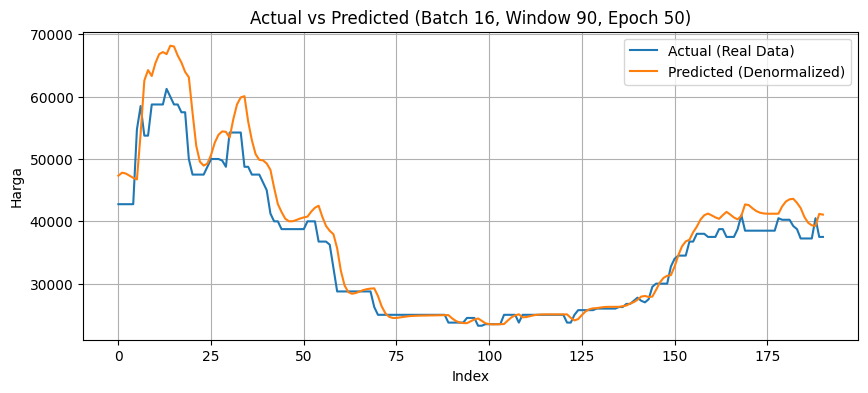

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_16_Window_90_Epoch_50.xlsx

[Proses] Training dengan Batch Size: 30 ...
   -> Selesai epoch : 50
   -> Best epoch    : 47 (val_loss=0.000808)
   -> Last loss     : 0.001033 | Last val_loss : 0.000959
6/6 [==============================] - 5s 102ms/step
   -> Selesai. Hasil MAPE: 3.3472%


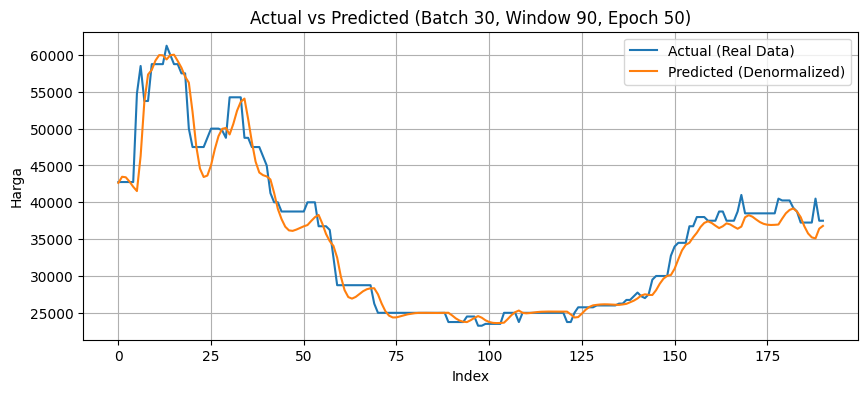

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_30_Window_90_Epoch_50.xlsx

[Proses] Training dengan Batch Size: 64 ...
   -> Selesai epoch : 50
   -> Best epoch    : 49 (val_loss=0.000944)
   -> Last loss     : 0.000899 | Last val_loss : 0.000987
6/6 [==============================] - 7s 186ms/step
   -> Selesai. Hasil MAPE: 3.3422%


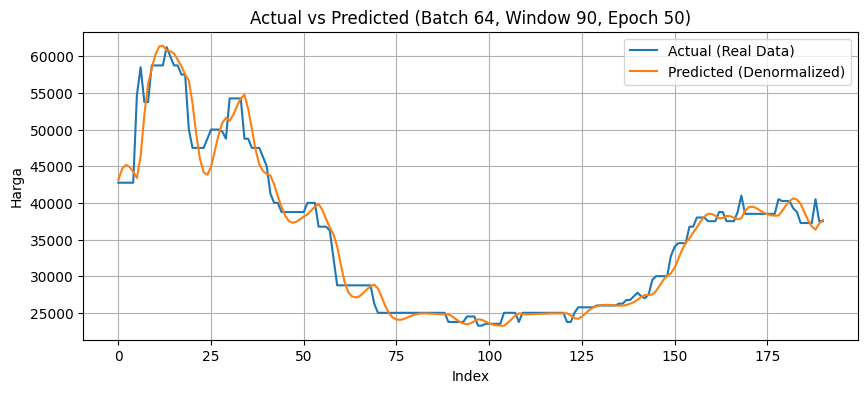

   ✓ Hasil disimpan ke: E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA\Prediksi_Batch_64_Window_90_Epoch_50.xlsx

   Batch Size  Best Epoch (val)  Best Val Loss  Last Loss  Last Val Loss  \
0          16                46       0.000737   0.001218       0.001011   
1          30                47       0.000808   0.001033       0.000959   
2          64                49       0.000944   0.000899       0.000987   

   MAPE (%)  
0  5.541996  
1  3.347179  
2  3.342225  
------------------------------------------------------------
KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):
1. Normalisasi : YA (MinMaxScaler; fit di segmen TRAIN, transform 100% data)
2. Window Size : 90
3. Epoch       : 50
4. Batch Size  : 64
MAPE Terendah  : 3.3422%


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==============================
# SEEDS
# ==============================
def reset_seeds():
    np.random.seed(42)
    python_random.seed(42)
    tf.random.set_seed(42)

reset_seeds()

# ==============================
# PATH
# ==============================
path_file_input = r"E:\Skripsi\Prediksi-bawang-merah\python\data\Data_Clean_Surabaya.xlsx"
path_output_folder = r"E:\SKRIPSI 2025\UJI COBA NORMALISASI DATA"
os.makedirs(path_output_folder, exist_ok=True)

# ==============================
# LOAD DATA
# ==============================
if os.path.exists(path_file_input):
    df = pd.read_excel(path_file_input)
    print("✓ Data berhasil dimuat.")
else:
    raise FileNotFoundError("File tidak ditemukan.")

raw_data = df['Harga (Rp)'].values.reshape(-1, 1)
print(f"✓ Jumlah baris asli (raw): {len(raw_data)}")  # Saran no. 1: info raw rows

# ==============================
# KONFIGURASI
# ==============================
FIXED_WINDOW_SIZE = 90
FIXED_EPOCH = 50
scenario_batch_sizes = [16, 30, 64]
VAL_RATIO = 0.1

# ==============================
# FUNGSI
# ==============================
def create_sliding_window(dataset, window_size):
    X, Y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size), 0])
        Y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(Y)

def build_model_lstm(input_shape):
    tf.random.set_seed(42)
    model = Sequential()
    # 2 LSTM layer
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.02))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.02))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')
    return model

# ==============================
# WINDOW DI SKALA ASLI (UNTUK AKTUAL)
# ==============================
X_full_raw, Y_full_raw = create_sliding_window(raw_data, FIXED_WINDOW_SIZE)
print(f"✓ Jumlah sampel window: {len(X_full_raw)} (window={FIXED_WINDOW_SIZE})")  # Saran no. 1: info window samples

train_size = int(len(X_full_raw) * 0.8)
y_test_orig = Y_full_raw[train_size:]  # data uji asli (sebelum normalisasi)

# ==============================
# FIT SCALER HANYA PADA TRAIN (HINDARI LEAKAGE)
# ==============================
raw_train_segment = raw_data[:train_size + FIXED_WINDOW_SIZE]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(raw_train_segment)

# Transform seluruh data dengan scaler yang di-fit dari TRAIN
scaled_data = scaler.transform(raw_data)
print("✓ Data ternormalisasi (0-1).")

# ==============================
# WINDOWING PADA DATA TER-SCALE
# ==============================
X_full_scaled, Y_full_scaled = create_sliding_window(scaled_data, FIXED_WINDOW_SIZE)
X_full_scaled = X_full_scaled.reshape(X_full_scaled.shape[0], X_full_scaled.shape[1], 1)

# Split 80:20 (berbasis window)
X_train_all, X_test = X_full_scaled[:train_size], X_full_scaled[train_size:]
y_train_all = Y_full_scaled[:train_size]

# Split validasi dari tail train
val_cut = int(len(X_train_all) * (1 - VAL_RATIO))
X_train, X_val = X_train_all[:val_cut], X_train_all[val_cut:]
y_train, y_val = y_train_all[:val_cut], y_train_all[val_cut:]

# ==============================
# INFO DATA
# ==============================
print(f"\n[Info] Dataset Window Size: {FIXED_WINDOW_SIZE}")
print("----------------------------------------")
print(f"Total Window Samples: {len(X_full_scaled)} | Latih: {len(X_train_all)} | Uji: {len(X_test)}")
print("----------------------------------------")

print("\n" + "="*60)
print("MULAI FASE 2: SKENARIO C (Mencari Batch Size Terbaik)")
print(f"Konfigurasi: Window {FIXED_WINDOW_SIZE} | Epoch {FIXED_EPOCH}")
print("="*60)

results = []

# ==============================
# LOOP BATCH SIZE
# ==============================
for batch_count in scenario_batch_sizes:
    print(f"\n[Proses] Training dengan Batch Size: {batch_count} ...")
    reset_seeds()

    # Bangun model
    model = build_model_lstm((X_train.shape[1], 1))

    # Training TANPA EarlyStopping (epoch tetap), DENGAN validation_data
    history = model.fit(
        X_train, y_train,
        epochs=FIXED_EPOCH,
        batch_size=batch_count,
        validation_data=(X_val, y_val),
        verbose=0,
        shuffle=False
    )

    # Ringkasan loss (Opsi A)
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    last_loss = float(train_loss[-1])
    if val_loss is not None:
        last_val_loss = float(val_loss[-1])
        best_epoch = int(np.argmin(val_loss) + 1)
        best_val = float(np.min(val_loss))
        print(f"   -> Selesai epoch : {FIXED_EPOCH}")
        print(f"   -> Best epoch    : {best_epoch} (val_loss={best_val:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f} | Last val_loss : {last_val_loss:.6f}")
    else:
        best_epoch = int(np.argmin(train_loss) + 1)
        best_tr = float(np.min(train_loss))
        print(f"   -> Selesai epoch : {FIXED_EPOCH}")
        print(f"   -> Best epoch    : {best_epoch} (loss={best_tr:.6f})")
        print(f"   -> Last loss     : {last_loss:.6f}")

    # Prediksi pada TEST (progress)
    predictions_scaled = model.predict(X_test, verbose=1)
    predictions_real = scaler.inverse_transform(predictions_scaled)

    # MAPE terhadap data uji asli
    mape = mean_absolute_percentage_error(y_test_orig, predictions_real) * 100
    print(f"   -> Selesai. Hasil MAPE: {mape:.4f}%")

    # Simpan ringkasan
    results.append({
        'Batch Size': batch_count,
        'Best Epoch (val)': best_epoch,
        'Best Val Loss': float(best_val) if val_loss is not None else None,
        'Last Loss': last_loss,
        'Last Val Loss': last_val_loss if val_loss is not None else None,
        'MAPE (%)': float(mape)
    })

    # ==============================
    # VISUALISASI: Actual vs Predicted (Denormalized)
    # ==============================
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='Actual (Real Data)')
    plt.plot(predictions_real, label='Predicted (Denormalized)')
    plt.title(f'Actual vs Predicted (Batch {batch_count}, Window {FIXED_WINDOW_SIZE}, Epoch {FIXED_EPOCH})')
    plt.xlabel('Index')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==============================
    # SIMPAN KE EXCEL (20% test)
    # ==============================
    y_test_safe = np.where(y_test_orig.flatten() == 0, np.finfo(float).eps, y_test_orig.flatten())
    err_pct = np.abs((y_test_orig.flatten() - predictions_real.flatten()) / y_test_safe) * 100

    out_df = pd.DataFrame({
        'Actual (Real)': y_test_orig.flatten(),
        'Predicted (Real)': predictions_real.flatten(),
        'Selisih': (y_test_orig.flatten() - predictions_real.flatten()),
        'Error (%)': err_pct
    })
    out_path = os.path.join(path_output_folder, f"Prediksi_Batch_{batch_count}_Window_{FIXED_WINDOW_SIZE}_Epoch_{FIXED_EPOCH}.xlsx")
    out_df.to_excel(out_path, index=False)
    print(f"   ✓ Hasil disimpan ke: {out_path}")

# ==============================
# HASIL AKHIR FINAL (KONFIGURASI TERBAIK)
# ==============================
print("\n" + "="*60)
results_df = pd.DataFrame(results)
print(results_df)

best_result = results_df.loc[results_df['MAPE (%)'].idxmin()]
best_batch = int(best_result['Batch Size'])

print("-" * 60)
print("KESIMPULAN FINAL (KONFIGURASI MODEL TERBAIK):")
print(f"1. Normalisasi : YA (MinMaxScaler; fit di segmen TRAIN, transform 100% data)")
print(f"2. Window Size : {FIXED_WINDOW_SIZE}")
print(f"3. Epoch       : {FIXED_EPOCH}")
print(f"4. Batch Size  : {best_batch}")
print(f"MAPE Terendah  : {best_result['MAPE (%)']:.4f}%")
print("="*60)